### Predecting salary

-  Here we are trying to predict the salary from the given information like job title, location ,company, job description.
-  For this we are using the cleaned data scraped from Indeed and seek
-  After that we are applying multiple classification models to see which model give better predicition and can be more generalised.

Here are we are predicting salary as a classificaiton problem having three class High, Medium and low. We converted salary data
into three class based on certain condition.

In [1079]:
import re
import itertools

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer



from sklearn.metrics import silhouette_score,confusion_matrix,classification_report


from sklearn.utils import resample


from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier,ExtraTreesClassifier

from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA,TruncatedSVD



from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore')

#### Import data file

In [1080]:
data_file = './data/cleaned_job_data'

In [1081]:
df_job_data = pd.read_csv(data_file)

In [1082]:
df_job_data.drop(['Unnamed: 0'],axis=1,inplace=True)

In [1083]:
df_job_data.shape

(1856, 5)

#### Working on all those data that has salary information

In [1084]:
df_salary_data = df_job_data[df_job_data['salary'].notnull()]

In [1085]:
df_salary_data.shape

(440, 5)

In [1086]:
df_salary_data.drop(df_salary_data[df_salary_data['job_desc'].isnull()].index,inplace=True)

In [1087]:
df_salary_data.shape

(438, 5)

In [1088]:
#drop all the salaries having 0 vlaues and salaries >200000
df_salary_data.drop(df_salary_data[df_salary_data['salary']==0.0].index,inplace=True)
df_salary_data.drop(df_salary_data['salary'][df_salary_data['salary'].apply(lambda x: len(str(x).split('.',1)[0])>7)].index,inplace=True)
df_salary_data.drop(df_salary_data['salary'][df_salary_data['salary'].apply(lambda x: len(str(x).split('.',1)[0])<5)].index,inplace=True)
df_salary_data.drop(df_salary_data[df_salary_data['salary']>200000].index,inplace=True)

In [1089]:
df_salary_data.shape

(360, 5)

In [1090]:
#function to classify salary as High, Medium and low
def categorize_salary(salary):
    if salary <= 70000:
           return 'Low'
    elif (salary > 70000) & (salary  <= 100000):
        return 'Medium'
    else:
        return 'High'

In [1091]:
df_salary_data['salary'] = df_salary_data['salary'].apply(lambda x: str(x))

In [1093]:
df_salary_data['salary'] = df_salary_data['salary'].apply(lambda x: categorize_salary(float(x)))

In [1094]:
#baseline
df_salary_data['salary'].value_counts(normalize=True)

High      0.683333
Medium    0.255556
Low       0.061111
Name: salary, dtype: float64

#### Trying to predict salary only with titles

In [1095]:
#Function to lemetize titles and description
def lemmatize_data(data):
    lemmatizer = WordNetLemmatizer()
    data = re.sub(r'[0-9]', '', data, flags=re.I)
    lem_verb = ' '.join([lemmatizer.lemmatize(each_word, pos='v') for each_word in word_tokenize(data)])
    lem_noun = ' '.join([lemmatizer.lemmatize(each_word, pos='n') for each_word in word_tokenize(lem_verb)])
    return lem_noun

In [1096]:
X_titles = df_salary_data['job_title'].apply(lambda x:lemmatize_data(x))

In [1097]:
X_titles.shape

(360,)

In [1098]:
#defining custom stop words of Tfidf
custom_stop_words = ['cbd','sydney','role','risk','specialist','vpsg','company','program','multiple','process']

In [1099]:
stopwords = stopwords.words('english')
stopwords.extend(custom_stop_words)

In [1100]:
#define a funciton to generate tfidf vector from text data
def create_tfidf_vec(data):
    tfidf = TfidfVectorizer(stop_words=stopwords,max_df=8,min_df=2,sublinear_tf=True,ngram_range=(1,2))
    tfidf.fit(data)
    X_vec = pd.DataFrame(tfidf.transform(data).todense(), columns=tfidf.get_feature_names())
    return X_vec

In [1101]:
X_titles_vec = create_tfidf_vec(X_titles)

In [1102]:
X_titles_vec.shape

(360, 213)

In [1103]:
#use this information to create your own custom words list. remove all the words that are not giving much information by adding them
#to stop words
#This are the top wordsin each document
word_counts = X_titles_vec.sum(axis=0)
word_counts.sort_values(ascending = False).head(100)

business systems           6.523104
reporting analyst          6.263547
data scientist             5.855561
database                   5.726878
analytics                  5.263839
intelligence analyst       4.701686
ict                        4.438883
dba                        4.122433
lead business              3.944307
analyst data               3.932751
java                       3.897045
junior business            3.874641
ict business               3.826435
operations                 3.768051
architect                  3.711463
senior data                3.553896
integration                3.530434
cloud                      3.461529
analyst business           3.389224
full                       3.361266
officer                    3.273420
technology                 3.247984
salesforce                 3.172611
financial                  3.171550
application                3.155452
sql developer              3.151823
insights analyst           3.141298
insights                   3

In [1104]:
#generate test-train split
def create_test_train_split(X,y):
    X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=43,test_size=0.33,shuffle=True)
    return X_train,X_test,y_train,y_test

In [1105]:
#define a funciton to generate different model results and return test and train score and also cross validated test train score
def generate_model_result(model_obj,X,y):
    X_train,X_test,y_train,y_test = create_test_train_split(X,y)
#    print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)
    model = model_obj.fit(X_train,y_train)
    training_score = model.score(X_train,y_train)
    testing_score = model.score(X_test,y_test)
    cv_train_score = np.mean(cross_val_score(model,X_train,y_train,cv=5,n_jobs=3))
    cv_test_score = np.mean(cross_val_score(model,X_test,y_test,cv=5,n_jobs=3))
    y_pred = model.predict(X_test)
    return training_score,testing_score,cv_train_score,cv_test_score,y_pred,y_test

In [1106]:
#lr = LogisticRegression(penalty='l2',C=0.5 , random_state=47, n_jobs=3)
# Logistic regression  model on job titles to predict salary
lr = LogisticRegression(penalty='l2',C=0.1 , random_state=47, n_jobs=3)


In [1107]:
#calling generate model funciton
training_score , testing_score ,cv_train_score,cv_test_score,y_pred,y_test = generate_model_result(lr,X_titles_vec,df_salary_data['salary'])

In [1108]:
#model result
training_score , testing_score ,cv_train_score,cv_test_score

(0.6804979253112033,
 0.6890756302521008,
 0.6807120674356699,
 0.6899183135704876)

In [1109]:
#define function to generate classificaiotn report
def genrate_classificatoin_report(y_test,y_pred):
    print(classification_report(y_test,y_pred))

In [1110]:
genrate_classificatoin_report(y_test,y_pred)

              precision    recall  f1-score   support

        High       0.69      1.00      0.82        82
         Low       0.00      0.00      0.00         3
      Medium       0.00      0.00      0.00        34

   micro avg       0.69      0.69      0.69       119
   macro avg       0.23      0.33      0.27       119
weighted avg       0.47      0.69      0.56       119



In [1111]:
#define a funciton to create confusion matrix
def generate_confusion_matrix(y_test,y_pred):
    class_names=['High','Low','Medium'] 
    cnf_matrix = metrics.confusion_matrix(y_test, y_pred)

    fig, ax = plt.subplots()

    sns.heatmap(pd.DataFrame(cnf_matrix,columns=['High','Low','Medium'],index=['High','Low','Medium']), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

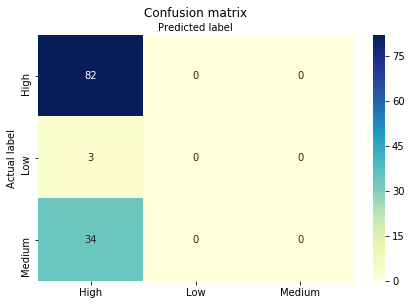

In [1112]:
generate_confusion_matrix(y_test,y_pred)

### Class Imbalance

- Above we can see that we have class imbalance and because of that our model is not performing good.
- To remove this class imbalance and to improve the performance we can resample the class that has lowe counts
- In our case we will resample Medium and Low class

In [387]:
df_salary_data['salary'].value_counts()

High      246
Medium     92
Low        22
Name: salary, dtype: int64

In [1123]:
#function to resample class
def upsample_class(df_salary_data):
    df_low = df_salary_data[df_salary_data['salary']=='Low']
    df_medium = df_salary_data[df_salary_data['salary']=='Medium']
    df_high = df_salary_data[df_salary_data['salary']=='High']  
    
    # Upsample minority class
    df_medium_upsampled = resample(df_medium, 
                                     replace=True,     # sample with replacement
                                     n_samples=223,    # to match majority class
                                     random_state=47) # reproducible results

    df_low_upsampled = resample(df_low, 
                                     replace=True,     # sample with replacement
                                     n_samples=215,    # to match majority class
                                     random_state=47) # reproducible results

    df_upsampled = pd.concat([df_medium_upsampled,df_low_upsampled,df_high])
 
    return df_upsampled

In [1124]:
df_salary_data.shape

(360, 5)

In [1125]:
df_upsampled = upsample_class(df_salary_data)

In [1126]:
df_upsampled.shape

(684, 5)

In [1127]:
#preprocess the text of resampled dataframe
X_upsampled_titles = df_upsampled['job_title'].apply(lambda x:lemmatize_data(x))

In [1128]:
X_upsampled_titles.shape

(684,)

In [1129]:
#generate the Tfidf vector from resampled dataframe
X_upsampled_titles_vec = create_tfidf_vec(X_upsampled_titles)

In [1130]:
X_upsampled_titles_vec.shape

(684, 277)

#### Reduce Dimensinality

- When we convert our text data into vector using TfIdf it will genrate huge sparse matrix.
- Using this sparse matrix might not give better prediction and not able to genralise for unseen data
- Therefore, we are using TruncatedSVD to reduce dimension and genralise model

In [1131]:
#reduce the dimention using TruncatedSVD
def reduce_dimensions(X,components):
    svd = TruncatedSVD(n_components=components)
    svd = svd.fit(X)
    print(svd.explained_variance_ratio_.sum())
    X_reduce_vec = svd.transform(X)
    return X_reduce_vec

In [1132]:
#only 70 components out of 277 can explain 80 of variance in our data
X_reduce_titles_vec = reduce_dimensions(X_upsampled_titles_vec,70)

0.8009009128975568


In [1133]:
X_reduce_titles_vec.shape

(684, 70)

In [1134]:
df_upsampled['salary'].shape

(684,)

In [1135]:
#lr = LogisticRegression(penalty='l2',C=5000, random_state=47, n_jobs=3)
#logistic regression on reduced dimension and resampled data with job titles
lr = LogisticRegression(penalty='l2',C=1900, random_state=47, n_jobs=3)

In [1136]:
#calling generate model function
training_score , testing_score ,cv_train_score,cv_test_score,y_pred,y_test = generate_model_result(lr,X_reduce_titles_vec,df_upsampled['salary'])

In [1137]:
#model result
training_score , testing_score ,cv_train_score,cv_test_score

(0.6986899563318777,
 0.6769911504424779,
 0.6615230491808332,
 0.6101537110232762)

In [1138]:
genrate_classificatoin_report(y_pred,y_test)

              precision    recall  f1-score   support

        High       0.48      0.93      0.63        43
         Low       0.97      0.57      0.72       129
      Medium       0.60      0.74      0.66        54

   micro avg       0.68      0.68      0.68       226
   macro avg       0.68      0.75      0.67       226
weighted avg       0.79      0.68      0.69       226



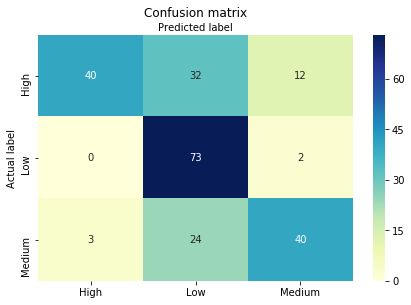

In [1139]:
generate_confusion_matrix(y_test,y_pred)

#### Predicting salary with job title and location using logisting regression

In [1140]:
#getting dummies of location
df_upsampled_location = pd.get_dummies(df_upsampled['location'])

In [1151]:
X_upsampled_titles_vec.shape, df_upsampled_location.shape

((684, 277), (684, 16))

In [1152]:
df_upsampled_location.reset_index(drop=True,inplace=True)

In [1153]:
#concatinating job titles vector with location
X_upsampled_titles_location_vec = pd.concat([X_upsampled_titles_vec,df_upsampled_location],axis=1,ignore_index=True)

In [1154]:
X_upsampled_titles_location_vec.shape

(684, 293)

In [1155]:
#with 50 components out of 293 we are able to explain 82% variance in our data
X_reduce_upsampled_titles_location_vec = reduce_dimensions(X_upsampled_titles_location_vec,50)

0.8244545759454374


In [1156]:
X_reduce_upsampled_titles_location_vec.shape

(684, 50)

In [1157]:
df_upsampled['salary'].shape

(684,)

In [1158]:
#lr = LogisticRegression(penalty='l2',C=1500, random_state=47, n_jobs=3)
#lr = LogisticRegression(penalty='l1',C=1500, random_state=47, n_jobs=3)
#logistic regresson on title and location
lr = LogisticRegression(penalty='l1',C=800, random_state=47, n_jobs=3)
#lr = LogisticRegression(penalty='l1',C=100, random_state=47, n_jobs=3)

In [1159]:
training_score , testing_score ,cv_train_score,cv_test_score,y_pred,y_test = generate_model_result(lr,X_reduce_upsampled_titles_location_vec,df_upsampled['salary'])

In [1160]:
#model result
training_score , testing_score ,cv_train_score,cv_test_score

(0.7379912663755459,
 0.7035398230088495,
 0.6876120606835895,
 0.6636012296881861)

In [1161]:
genrate_classificatoin_report(y_test,y_pred)

              precision    recall  f1-score   support

        High       0.82      0.56      0.67        84
         Low       0.61      0.97      0.75        75
      Medium       0.80      0.58      0.67        67

   micro avg       0.70      0.70      0.70       226
   macro avg       0.74      0.70      0.70       226
weighted avg       0.74      0.70      0.70       226



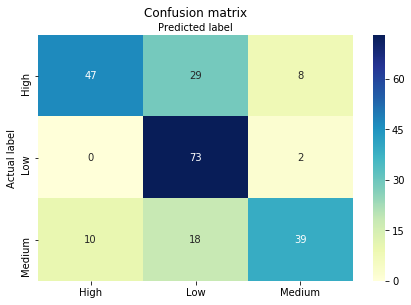

In [1163]:
generate_confusion_matrix(y_test,y_pred)

#### Using job titles, location and job description to predict salary

In [1164]:
df_upsampled_job_desc = df_upsampled['job_desc']

In [1165]:
df_upsampled_job_desc.reset_index(drop=True,inplace=True)


In [1166]:
X_upsampled_job_desc = df_upsampled['job_desc'].apply(lambda x:lemmatize_data(x))

In [1167]:
#generating tfidf vector of pre processed job dscription text
X_upsampled_job_desc_vec = create_tfidf_vec(X_upsampled_job_desc)

In [1169]:
X_upsampled_job_desc_vec.shape

(684, 14817)

In [1170]:
X_upsampled_titles_location_vec.shape

(684, 293)

In [1171]:
#generating vector of title, location and description by concatinating them
X_upsampled_titles_location_desc_vec = pd.concat([X_upsampled_titles_location_vec,X_upsampled_job_desc_vec],axis=1,ignore_index=True)

In [1172]:
X_upsampled_titles_location_desc_vec.shape

(684, 15110)

In [1173]:
#with 150 components out of 15110 can explain 88% variance of our data
X_reduce_upsampled_title_location_desc_vec = reduce_dimensions(X_upsampled_titles_location_desc_vec,150)

0.8878906958569998


In [582]:
X_reduce_upsampled_title_location_desc_vec.shape, df_upsampled['salary'].shape

((684, 150), (684,))

In [1180]:
#lr = LogisticRegression(penalty='l2',C=3, random_state=47, n_jobs=3)
#logistic regrssion with title,location and description
lr = LogisticRegression(penalty='l1',C=250, random_state=47, n_jobs=3)
#lr = LogisticRegression(penalty='l1',C=5000, random_state=47, n_jobs=3)

In [1181]:
training_score , testing_score ,cv_train_score,cv_test_score,y_pred,y_test = generate_model_result(lr,X_reduce_upsampled_title_location_desc_vec,df_upsampled['salary'])

In [1182]:
#test result
training_score , testing_score ,cv_train_score,cv_test_score

(0.9672489082969432, 0.8849557522123894, 0.814466038869966, 0.7074659639877031)

In [1183]:
genrate_classificatoin_report(y_test,y_pred)

              precision    recall  f1-score   support

        High       0.97      0.75      0.85        84
         Low       0.85      1.00      0.92        75
      Medium       0.85      0.93      0.89        67

   micro avg       0.88      0.88      0.88       226
   macro avg       0.89      0.89      0.88       226
weighted avg       0.89      0.88      0.88       226



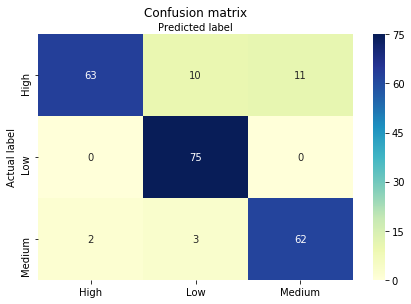

In [1184]:
generate_confusion_matrix(y_test,y_pred)

#### Predicting salary using Support Vector Machine on title,location, and description

In [1185]:
#svm_model = SVC(kernel='rbf',C=10,gamma=0.5)
#svm_model = SVC(kernel='rbf',C=7,gamma=0.5)

svm_model = SVC(kernel='rbf',C=5,gamma=0.5)

In [1186]:
training_score , testing_score ,cv_train_score,cv_test_score,y_pred,y_test = generate_model_result(svm_model,X_reduce_upsampled_title_location_desc_vec,df_upsampled['salary'])

In [1187]:
#model result
training_score , testing_score ,cv_train_score,cv_test_score

(0.8951965065502183,
 0.8584070796460177,
 0.8077074631773089,
 0.7337505489679403)

In [1188]:
genrate_classificatoin_report(y_test,y_pred)

              precision    recall  f1-score   support

        High       0.95      0.69      0.80        84
         Low       0.75      1.00      0.86        75
      Medium       0.94      0.91      0.92        67

   micro avg       0.86      0.86      0.86       226
   macro avg       0.88      0.87      0.86       226
weighted avg       0.88      0.86      0.86       226



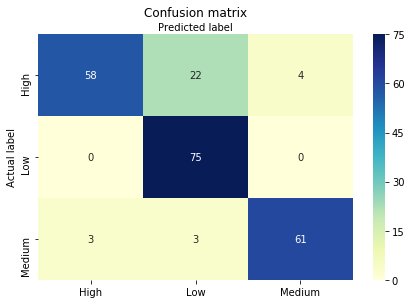

In [1189]:
generate_confusion_matrix(y_test,y_pred)

#### Prediction salary using Random Forest

In [1]:
# forest_clf=RandomForestClassifier(n_estimators=50,max_depth=12,random_state=43,criterion='gini', \
#                                  max_features=30)
# forest_clf=RandomForestClassifier(n_estimators=50,max_depth=12,random_state=43,criterion='gini', \
#                                  max_features=10)
# forest_clf=RandomForestClassifier(n_estimators=10,max_depth=5,random_state=43,criterion='gini', \
#                                  max_features=2)
forest_clf=RandomForestClassifier(n_estimators=10,max_depth=7,random_state=43,criterion='gini', \
                                 max_features=10)

NameError: name 'RandomForestClassifier' is not defined

In [1200]:
training_score , testing_score ,cv_train_score,cv_test_score,y_pred,y_test = generate_model_result(forest_clf,X_reduce_upsampled_title_location_desc_vec,df_upsampled['salary'])

In [1201]:
training_score , testing_score ,cv_train_score,cv_test_score

(0.9650655021834061, 0.9336283185840708, 0.8951682258835134, 0.849534475186649)

In [1202]:
genrate_classificatoin_report(y_test,y_pred)

              precision    recall  f1-score   support

        High       0.95      0.90      0.93        84
         Low       0.89      1.00      0.94        75
      Medium       0.97      0.90      0.93        67

   micro avg       0.93      0.93      0.93       226
   macro avg       0.94      0.93      0.93       226
weighted avg       0.94      0.93      0.93       226



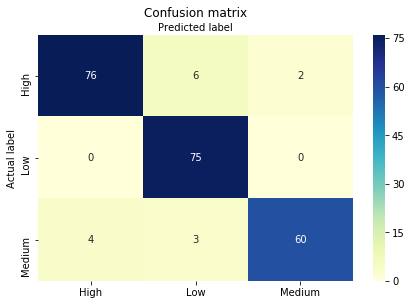

In [1203]:
generate_confusion_matrix(y_test,y_pred)

In [ ]:
#### Predicting salary using BaggingClassifier

In [ ]:
#bag_model = BaggingClassifier(n_estimators=1000)
bag_model = BaggingClassifier(n_estimators=500,n_jobs=3,max_samples=100,max_features=50)
bag_model = BaggingClassifier(n_estimators=300,n_jobs=3,max_samples=50,max_features=50)
#bag_model = BaggingClassifier(n_estimators=300,n_jobs=3,max_samples=30,max_features=30)

#bag_model = BaggingClassifier(n_estimators=300)

In [1205]:
training_score , testing_score ,cv_train_score,cv_test_score,y_pred,y_test = generate_model_result(bag_model,X_reduce_upsampled_title_location_desc_vec,df_upsampled['salary'])

In [1206]:
#model result
training_score , testing_score ,cv_train_score,cv_test_score

(0.9344978165938864, 0.9203539823008849, 0.888669348416894, 0.8720553359683795)

In [1207]:
genrate_classificatoin_report(y_test,y_pred)

              precision    recall  f1-score   support

        High       0.96      0.89      0.93        84
         Low       0.87      0.99      0.93        75
      Medium       0.94      0.88      0.91        67

   micro avg       0.92      0.92      0.92       226
   macro avg       0.92      0.92      0.92       226
weighted avg       0.92      0.92      0.92       226



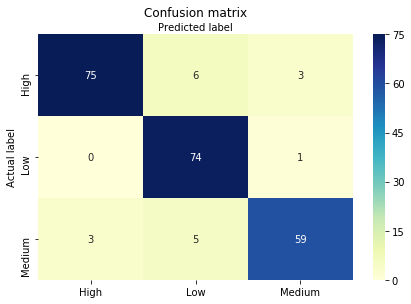

In [1208]:
generate_confusion_matrix(y_test,y_pred)